# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
*   Triaxial Angular velocity from the gyroscope
*   A 561-feature vector with time and frequency domain variables
*   The activity label

More information about the features are available on the website linked above.


In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

*   Examine the data types--there are many columns, so it might be wise to use value counts.
*   Determine if the floating point values need to be scaled.
*   Determine the breakdown of each activity.
*   Encode the activity label as an integer.


In [4]:
### BEGIN SOLUTION
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data columns are all floats except for the activity label.


In [5]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [6]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [7]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [8]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [9]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.\
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

6286    1
7886    0
9446    1
3199    4
368     2
Name: Activity, dtype: int32

## Question 2

*   Calculate the correlations between the dependent variables.
*   Create a histogram of the correlation values.
*   Identify those that are most correlated (either positively or negatively).


In [11]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
# for coord in zip(*tril_index): 
#     corr_values.iloc[coord[0], coord[1]] = np.NaN code they gave me which is more explicit
corr_array = np.array(corr_values)
corr_array[np.tril_indices_from(corr_values)] = np.nan # code in the video which is numpy and faster


# Stack the data and convert to a data frame
corr_values = pd.DataFrame(corr_array, columns= corr_values.columns, index= corr_values.index)

corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

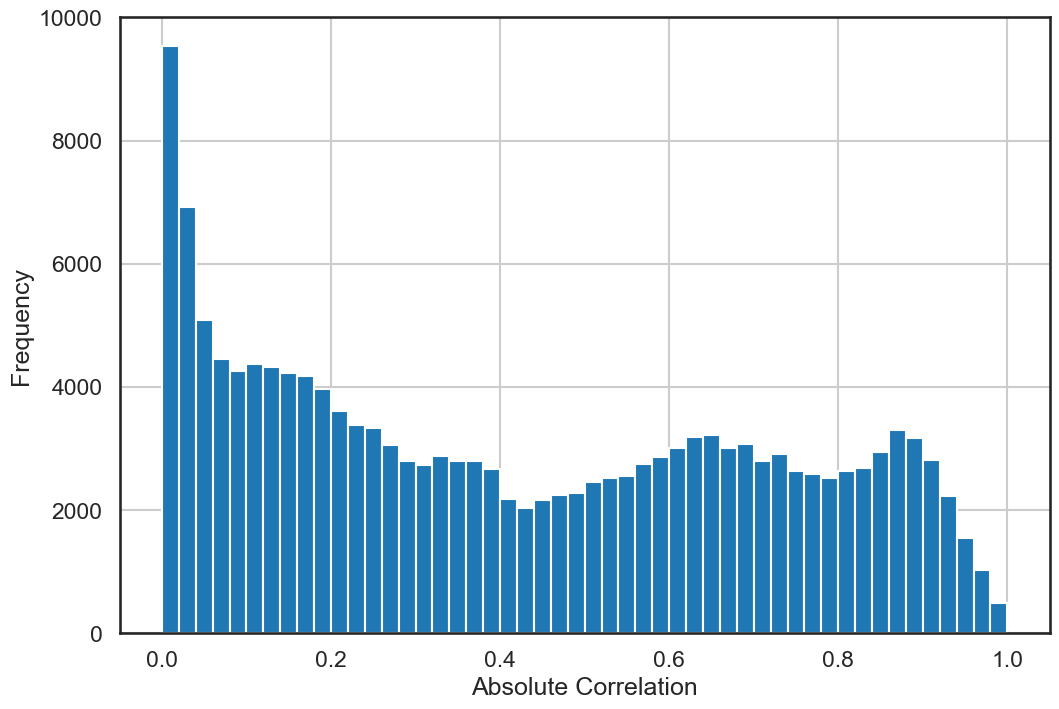

In [13]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [14]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


In [15]:
corr_values.shape

(157080, 4)

## Question 3

*   Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
*   Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [16]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [17]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [18]:
y_test.value_counts(normalize=True)
### END SOLUTION

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

*   Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
*   Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [19]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [20]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [21]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

*   Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.


In [22]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
249 -0.037590 -0.467799  0.166908 -0.218734 -0.226025  0.329632  0.000000   
50   0.317225  1.904829 -2.562046  0.248908  0.348187 -1.277040  0.000000   
31  -0.062221  0.258954 -0.298633 -0.246105  0.026193  0.257929  0.000000   
470 -0.002536  0.189292  0.207267  0.161016 -0.248712  0.206621  0.000000   
370  0.129000 -0.061671  0.174566  0.691986  0.150179 -0.121212  0.000000   
490 -0.005601  0.201102  0.230080 -0.457311  0.115453  1.016859 -0.038124   
340  0.003508  0.211189  0.203123  0.202091  0.080833  0.068443  0.000000   
396 -0.021049  0.089008  0.044540  0.253660  0.046685 -0.212155  0.000000   
51   0.138023  0.767952 -0.453760 -0.270294  0.100796 -0.664212  0.000000   
199 -0.073598  0.467436  0.195564  0.744608  0.579544 -1.152761  0.000000   

                                                             l2            \
            1         2         3         4         5         0         1   
249 -0.873459  0.000000  0.000000 -0.012787  2.541999 -0.061506 -0.482485   
50   0.755313  0.000000  0.000000  0.000000 -5.411645  0.394311  3.396302   
31   0.168180 -0.905177 -0.120112  0.000000  0.613709 -0.138194  1.097337   
470  0.250470  0.031480  0.000000 -0.048589  0.316118 -0.024931  0.408321   
370 -0.012194  0.083628  1.056799  0.000000 -0.119297  0.266889  0.013570   
490  0.077115  0.487455 -0.047089 -0.001892  0.850053 -0.031168  0.481576   
340  0.182789  0.000000  0.000000  0.041834  0.411904 -0.015037  0.486330   
396  0.000000  0.000000  0.253298  0.000000 -0.324138 -0.055317  0.007321   
51   0.000000  0.000000  0.000000  0.000000 -2.354700  0.102609  1.231713   
199  0.480127  0.207172  1.041984  1.772304 -3.463900 -0.115852  0.413580   

                                             
            2         3         4         5  
249  0.285802 -1.023203 -0.593668  0.907984  
50  -3.186460  1.048496  0.837877 -2.920108  
31  -0.511089 -0.977671  0.058687  0.998663  
470  0.216533  0.573123 -0.373514  0.274050  
370  0.170830  2.434665  0.061232 -0.176663  
490  0.299286 -1.435673  0.235871  2.425268  
340  0.228634  0.563130  0.105651  0.193757  
396  0.074404  0.428397  0.215022 -0.257385  
51  -0.491164 -0.793998  0.201677 -1.309535  
199  0.312493  1.710507  1.411093 -2.464471

In [29]:
coefficients.shape

(561, 18)

Prepare six separate plots for each of the multi-class coefficients.


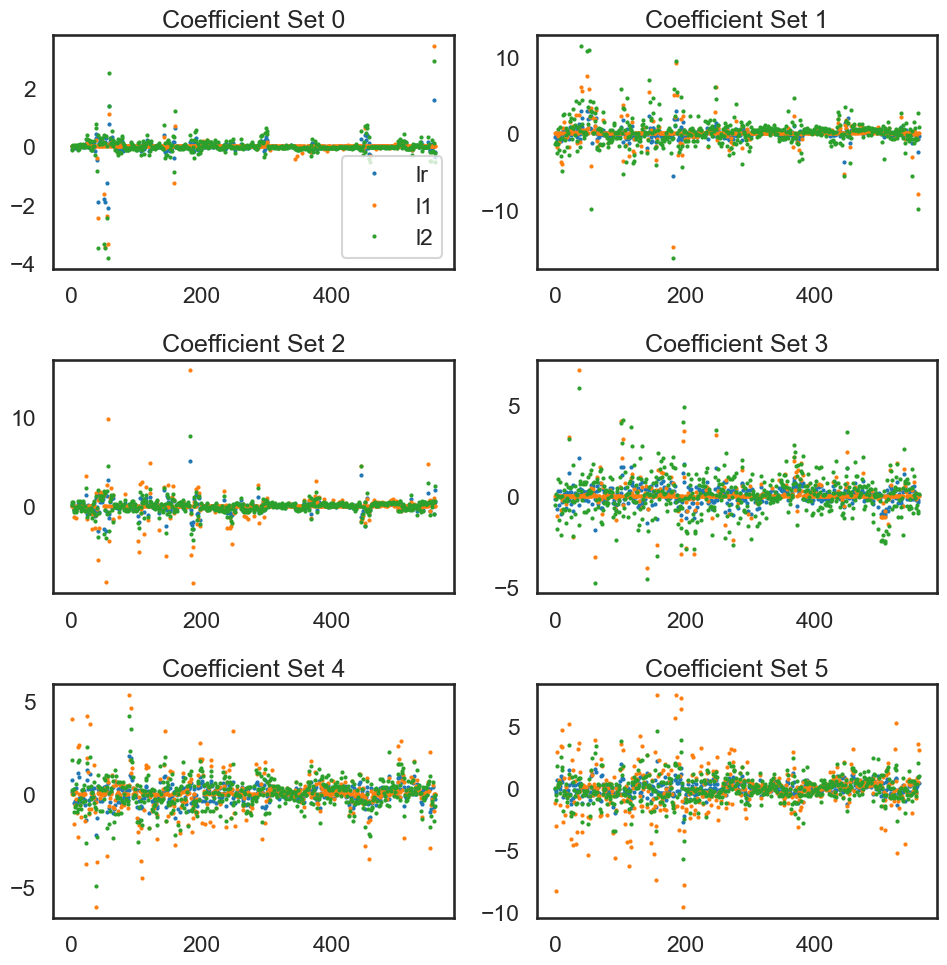

In [30]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

*   Predict and store the class for each model.
*   Store the probability for the predicted class for each model.


In [37]:
pd.DataFrame(lr.predict_proba(X_test)) # probabailities for each row for each outcome

,0,1,2,3,4,5
0,0.000034,1.683461e-04,5.675962e-04,9.989388e-01,6.320911e-06,2.845352e-04
1,0.000037,3.211720e-07,4.237865e-06,1.424984e-04,1.165029e-02,9.881654e-01
2,0.000036,4.352781e-03,2.962601e-06,9.875917e-01,5.010528e-03,3.006542e-03
3,0.000223,9.813812e-01,1.838393e-02,1.419653e-07,1.192660e-05,1.288314e-12
4,0.998277,1.717718e-03,3.008375e-09,2.088804e-07,5.146962e-06,1.393959e-10
...,...,...,...,...,...,...
3085,0.000038,4.541393e-01,5.434698e-01,2.297524e-03,2.166714e-05,3.359793e-05
3086,0.000089,1.287028e-04,2.437030e-05,9.033540e-01,3.474005e-05,9.636964e-02
3087,0.000024,9.696418e-01,3.032824e-02,4.115009e-09,4.090160e-06,2.039718e-06
3088,0.000055,9.868403e-01,1.224295e-03,2.686253e-07,2.893133e-07,1.187970e-02


In [24]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [38]:
y_pred[y_pred.lr != y_pred.l1]

,lr,l1,l2
88,2,1,1
197,2,1,1
296,1,2,1
388,1,2,1
430,4,5,4
489,2,1,1
769,4,3,3
853,5,3,3
1036,1,2,1
1071,1,2,2


In [40]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998907,0.999757
1,0.988165,0.999387,0.999477
2,0.987592,0.995209,0.999662
3,0.981381,0.999205,0.994338
4,0.998277,0.999919,0.999997


## Question 7

For each model, calculate the following error metrics:

*   Accuracy
*   Precision
*   Recall
*   F-score
*   Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [45]:
score(y_test,y_pred['lr'],average='weighted') # [0] is the precision for each of the labels, [1] is recall, [2] is the f-score, [3] is support
# score(y_test,y_pred['lr'],average='weighted') # average for each error metric

(0.9841438255400277, 0.9841423948220065, 0.984142828415666, None)

In [47]:
# label_binarize(y_test, classes=[0,1,2,3,4,5])
y_prob['lr']

0       0.998939
1       0.988165
2       0.987592
3       0.981381
4       0.998277
          ...   
3085    0.543470
3086    0.903354
3087    0.969642
3088    0.986840
3089    0.989854
Name: lr, Length: 3090, dtype: float64

In [48]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [49]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.983835,0.983824
recall,0.984142,0.983819,0.983819
fscore,0.984143,0.983815,0.983819
accuracy,0.984142,0.983819,0.983819
auc,0.990384,0.990144,0.990165


## Question 8

*   Display or plot the confusion matrix for each model.


In [51]:
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

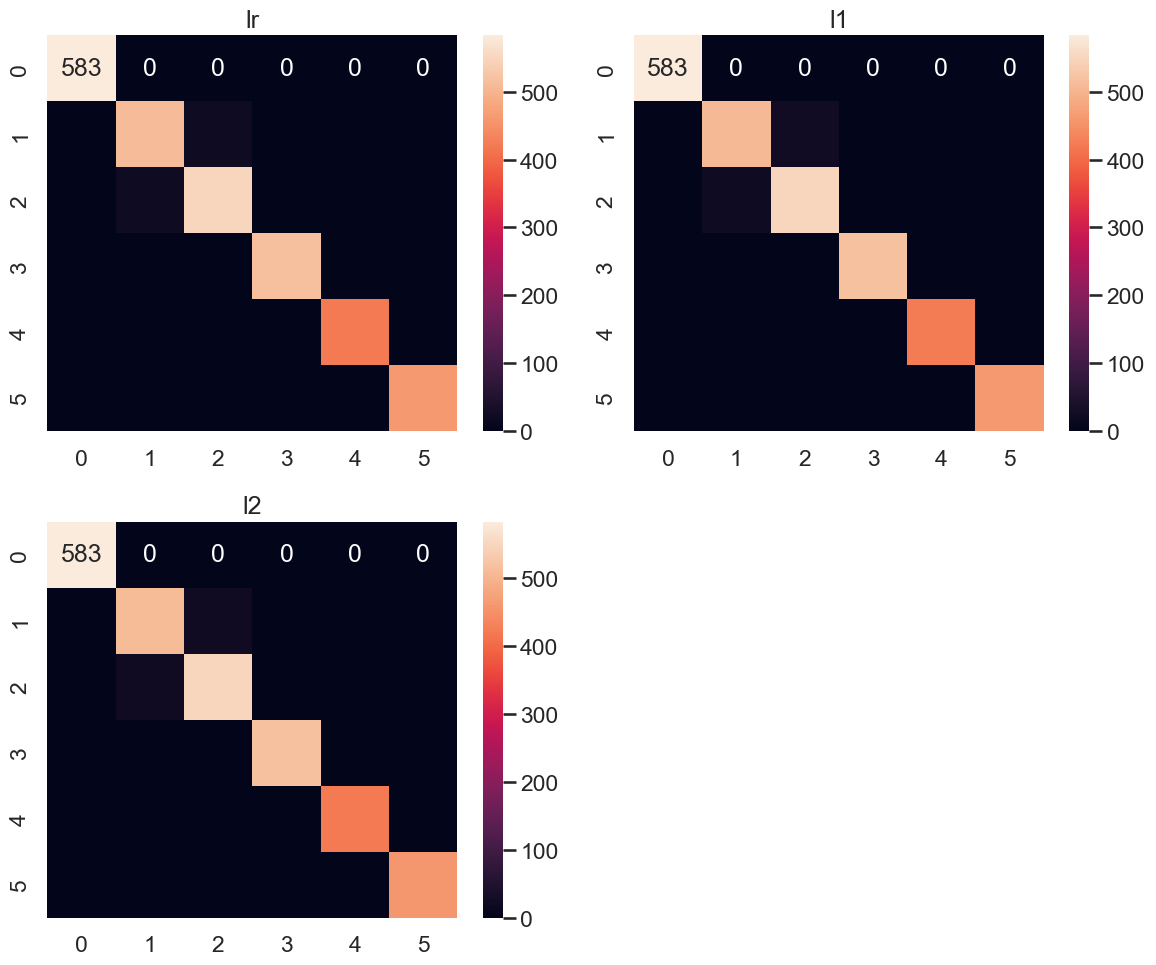

In [28]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

***

### Machine Learning Foundation (C) 2020 IBM Corporation
